# Descriptive analsysis

### import modules

In [2]:
import sys
import os
os.chdir('/home/amorales/Documents/projects/bias_2')
import pickle

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score
sys.path.append('src/models')
from utils import StratifiedGroupKFold, get_sample_balanced_weight

import matplotlib.pyplot as plt
import seaborn as sns
import re

import itertools

import MDAnalysis as mda
import nglview as nv

In [3]:
sys.path.append('src/utils')
from get_BW_nomenclature import get_bw

In [4]:
bw_dict = get_bw('6PT0')

In [5]:
# reformat dict
clean_bw_dict = {}
for k, v in bw_dict.items():
    bw = re.findall('\d+\.\d+',v)

    if not bw:
        continue

    clean_bw_dict[k[1:]] = bw[0]

## Functions

In [6]:
def get_low_corr_df(df, feature_cols, max_corr):
    """Generates a dataframe without high correlated features

    Args:
        df (pandas.DataFrame): dataframe holding features and optionally labels, and groups
        feature_cols (list): a list holding the column names of df that correspond to features
        max_corr (float): Scalar between 0 and 1 that defines the max correlation present in clean_df and used to build the correlation dictionary

    Returns:
        clean_df (pandas.DataFrame): DataFrame holding a version of df with a max correlation below max_corr
        corr_dict (dict): Dictionary relating one feature to all the residues with a correlation higher than max_corr
        
    """
    
    real_corr_matrix = df[feature_cols].corr()
    abs_corr_matrix = real_corr_matrix.abs()
    # Extract the upper trinagule from the correlation matrix
    upper = abs_corr_matrix.where(
        np.triu(np.ones(abs_corr_matrix.shape),  k=1).astype(np.bool))
    # Remove redundant features with a correlation higher than max_corr
    to_drop = [column for column in upper.columns if any(upper[column] > max_corr)]
    clean_df = df.drop(to_drop, axis=1)
    
    # Generate correlation dict
    corr_dict = {}
    for feat in feature_cols:
        
        # get a mask for features highly correlated to feat 
        high_corr_mask = abs_corr_matrix[str(feat)] > max_corr
        
        # Get the column names corresponding to those features
        cols = real_corr_matrix.columns[high_corr_mask]
        
        # link feat and the set of columns in the correlation dict
        corr_dict[feat] = cols
    
    return clean_df, corr_dict

In [7]:

def plot_contacts(contacts, plot_motifs=True):
    
    color_dict = {i:color for i, color in enumerate(sns.color_palette())}
    
    micro_switch_dict = {'dry': range(130, 133),
                     'npxxy': range(295, 300),
                     'cwp': range(257, 261),
                     'pif': [121, 201, 254],
                     'sod_bs': [80, 120, 291, 292],
                     'toogle_s': [258],
                     '6.30': [240]}
    color_list = ['green', 'red', 'blue', 'orange',
            'purple', 'yellow', 'grey']
    

#     u = mda.Universe('data/output/topologies/topology_1.pdb')
    
    u = mda.Universe('data/interim/aligned_sims/WT/structure.psf','data/interim/wt.pdb')
    
    sel = u.select_atoms('protein or resname 8D0')

    w = nv.show_mdanalysis(sel, default=False)
    w.background = 'white'
    w.camera = 'orthographic'

    w.add_cartoon('protein', color='white')
    w.add_spacefill('[8D0]', color='lime')
    w.center()


    shape = nv.shape.Shape(view=w)
    
    if plot_motifs:
        for (ms, res), color in zip(micro_switch_dict.items(), color_list):
            res_list = list(res)
            res_str = ' '.join(map(str, res_list))

            w.add_spacefill(f'({res_str}) and .CA', color=color)

    for i, (contact, count, bw, diff) in contacts.iterrows():

        r1, r2 = [res for res in contact.split('-')]
        
        sel_str = []
        
        for r in [r1, r2]:
            if r == 'LIG':
                sel_str.append('(resname 8D0 and name C1)')
            else:
                sel_str.append(f'(resid {r} and name CA)')

        space = ' '

        s = u.select_atoms(' or '.join(sel_str))
        r1_xyz, r2_xyz = s.positions[:2].tolist()
        
        color_idx = 1 if diff < 0 else 0

        shape.add_cylinder(r1_xyz, r2_xyz, color_dict[color_idx], count, bw)
        
    w.background = 'white'
    return w

## Contact Stability

### Load contact stability data


In [59]:
contact_df = pd.read_csv('data/processed/features_new.csv', index_col=0)
contact_df.mutant_id = contact_df.mutant_id.astype(str)

feature_cols = np.array([c for c in contact_df.columns if '-' in c])
non_feature_cols = np.array([c for c in contact_df.columns if '-' not in c])

contact_df = contact_df[np.concatenate([non_feature_cols ,feature_cols])]

/home/amorales/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [60]:
clean_contact_df, contact_corr_dict = get_low_corr_df(contact_df, feature_cols, 0.6)
# Create a list with the new feature cols
clean_feature_cols = np.array([c for c in clean_contact_df.columns if '-' in c])

In [61]:
clean_contact_df

,mutant_id,replica,profile,242-246,116-119,166-170,215-240,34-38,127-73,23-271,...,16-97,17-24,16-98,16-96,207-227,16-26,16-33,17-26,16-30,133-226
3,33,4,0,1.000,0.380,1.000,0.000,0.988,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,5,0,1.000,0.565,0.995,0.000,1.000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,33,6,0,1.000,0.463,0.993,0.005,0.995,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,33,7,0,1.000,0.472,1.000,0.000,0.990,0.018,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,33,8,0,1.000,0.510,0.993,0.260,0.998,0.003,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0,0.993,0.537,0.998,0.000,1.000,0.472,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
249,wt,5,0,1.000,0.463,0.985,0.000,1.000,0.265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
250,wt,6,0,1.000,0.545,1.000,0.138,1.000,0.520,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,wt,7,0,1.000,0.568,0.990,0.000,1.000,0.347,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compare distribtution between signaling profiles

In [25]:
# Remove the most important residue for the tree
# Refit the tree
# Parse tree deision process
# Store:
#   classification vectors
#   involved residues and thresholds
#   

In [26]:
contact_df

,mutant_id,replica,profile,242-246,116-119,166-170,215-240,34-38,127-73,124-205,...,16-96,207-227,16-26,16-33,17-26,16-30,133-226,287-39,285-291,130-135
3,33,4,0,1.000,0.380,1.000,0.000,0.988,0.000,0.297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
4,33,5,0,1.000,0.565,0.995,0.000,1.000,0.000,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
5,33,6,0,1.000,0.463,0.993,0.005,0.995,0.000,0.297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
6,33,7,0,1.000,0.472,1.000,0.000,0.990,0.018,0.325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
7,33,8,0,1.000,0.510,0.993,0.260,0.998,0.003,0.305,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,wt,4,0,0.993,0.537,0.998,0.000,1.000,0.472,0.357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003,0.003,0.000
249,wt,5,0,1.000,0.463,0.985,0.000,1.000,0.265,0.378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
250,wt,6,0,1.000,0.545,1.000,0.138,1.000,0.520,0.325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000
251,wt,7,0,1.000,0.568,0.990,0.000,1.000,0.347,0.325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000


In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2,
                                class_weight='balanced',
                                min_impurity_decrease= 0.05, min_samples_split=10, n_estimators=10000)
feature_cols = np.array([c for c in contact_df.columns if '-' in c])
X = contact_df.drop(['mutant_id', 'replica', 'profile'], axis=1)
y = contact_df.profile
clf.fit(X, y)
print(clf.score(X, y))
importances = clf.feature_importances_

1.0


In [28]:
importance_df = pd.DataFrame({'contact': X.columns, 'importance': importances})

In [29]:
importance_df = importance_df[importance_df.importance > 0]

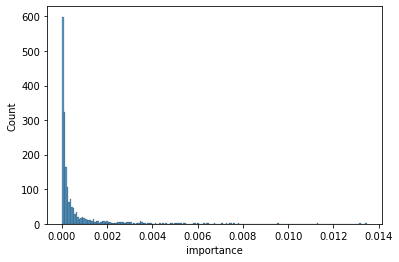

In [30]:
sns.histplot(data=importance_df, x='importance')
plt.show()

In [31]:
importance_df = importance_df.sort_values('importance', ascending=False)

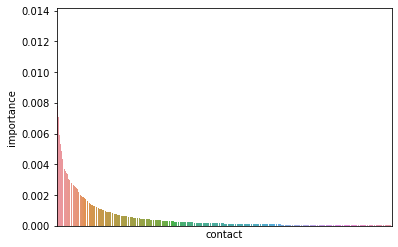

In [32]:
sns.barplot(data=importance_df, x='contact', y='importance')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

In [33]:
n = 20

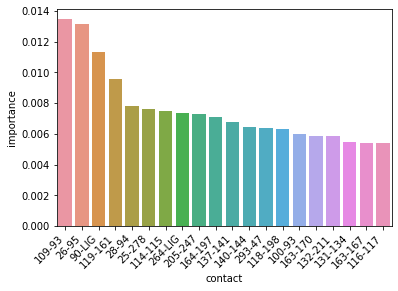

In [34]:
sns.barplot(data=importance_df.iloc[:n], x='contact', y='importance')
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
top_importance_df = importance_df.iloc[:n]

In [36]:
bw_list = []

for c in top_importance_df.contact:
    bw_pair = []
    for res in c.split('-'):
                
        res = clean_bw_dict.get(res, res)
            
        bw_pair.append(res)
    
    bw_list.append('-'.join(map(str, bw_pair)))

In [37]:
top_importance_df['bw_contact'] = bw_list

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
top_importance_df

,contact,importance,bw_contact
1081,109-93,0.013472,3.28-2.63
2362,26-95,0.013161,26-2.65
1375,90-LIG,0.011304,2.60-LIG
731,119-161,0.009582,3.38-4.53
699,28-94,0.007797,28-2.64
1237,25-278,0.007605,25-7.32
2046,114-115,0.007492,3.33-3.34
1949,264-LIG,0.007383,6.54-LIG
2247,205-247,0.007308,5.54-6.37
1046,164-197,0.007102,4.56-5.46


In [39]:
imp_min = top_importance_df.importance.min()
imp_max = top_importance_df.importance.max()
top_importance_df.importance = (top_importance_df.importance - imp_min) / (imp_max - imp_min) * 1.5 + 0.5

/home/amorales/.virtualenvs/bias/lib64/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
top_importance_df

,contact,importance,bw_contact
1081,109-93,2.000000,3.28-2.63
2362,26-95,1.942117,26-2.65
1375,90-LIG,1.597277,2.60-LIG
731,119-161,1.277621,3.38-4.53
699,28-94,0.946174,28-2.64
1237,25-278,0.910485,25-7.32
2046,114-115,0.889542,3.33-3.34
1949,264-LIG,0.869174,6.54-LIG
2247,205-247,0.855215,5.54-6.37
1046,164-197,0.817020,4.56-5.46


In [41]:
diff_list = []
for contact in top_importance_df.contact:
    wt_mean = contact_df[contact_df.profile == 0][contact].mean()
    bias_mean = contact_df[contact_df.profile == 1][contact].mean()
    diff = wt_mean - bias_mean
    diff_list.append(diff)

In [42]:
top_importance_df['diff'] = diff_list

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
color_dict = {i:color for i, color in enumerate(sns.color_palette())}

In [44]:
top_importance_df

,contact,importance,bw_contact,diff
1081,109-93,2.000000,3.28-2.63,0.186981
2362,26-95,1.942117,26-2.65,-0.273510
1375,90-LIG,1.597277,2.60-LIG,0.097529
731,119-161,1.277621,3.38-4.53,0.109995
699,28-94,0.946174,28-2.64,0.077248
1237,25-278,0.910485,25-7.32,-0.206914
2046,114-115,0.889542,3.33-3.34,-0.029010
1949,264-LIG,0.869174,6.54-LIG,-0.022105
2247,205-247,0.855215,5.54-6.37,0.015805
1046,164-197,0.817020,4.56-5.46,0.092143


In [46]:
plot_contacts(top_importance_df)

NGLWidget()

In [47]:
from sklearn.neighbors import KernelDensity

In [48]:
top_importance_df = top_importance_df.reset_index(drop=True)

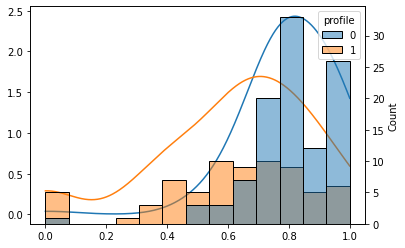

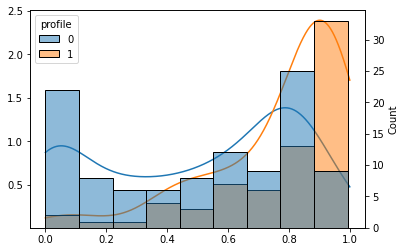

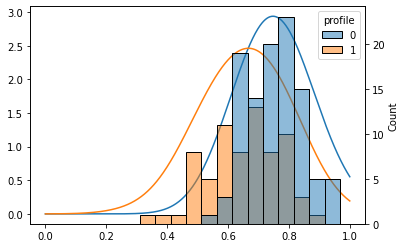

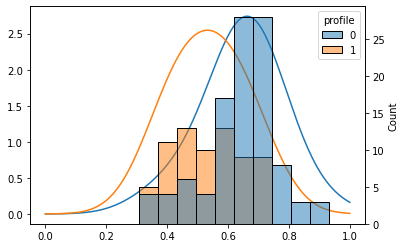

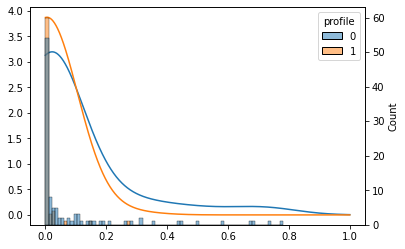

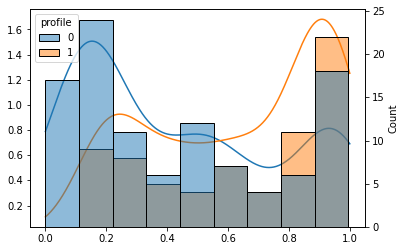

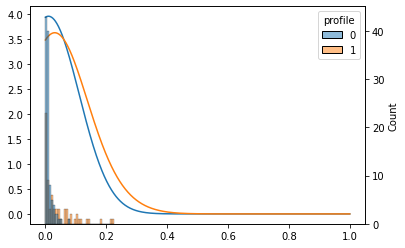

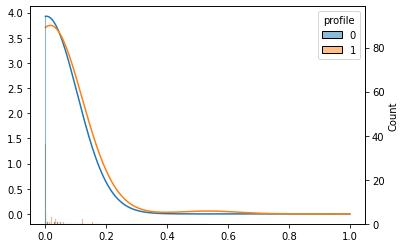

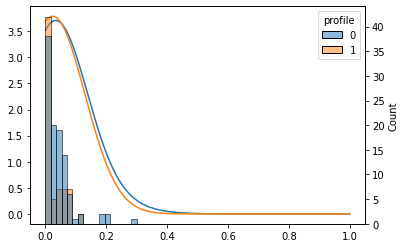

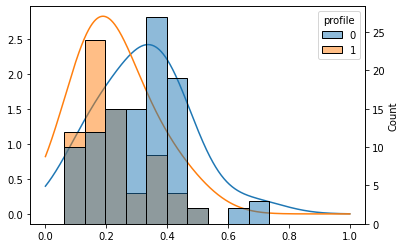

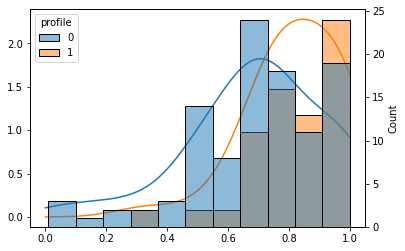

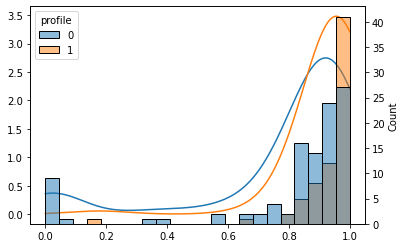

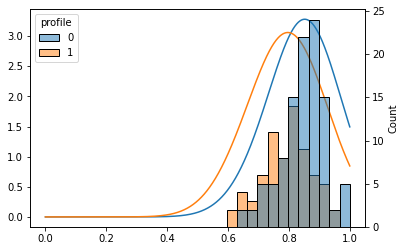

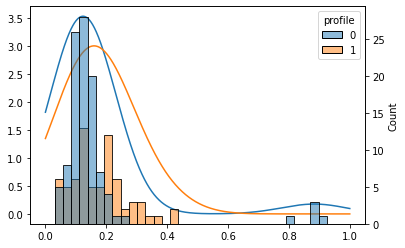

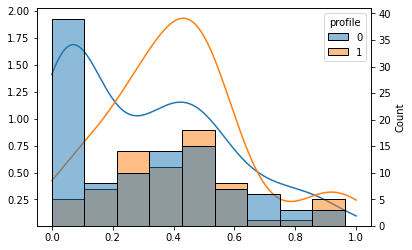

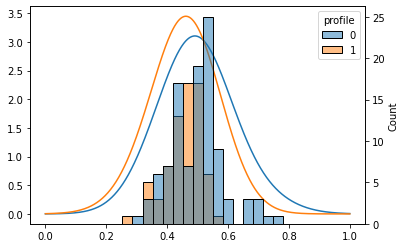

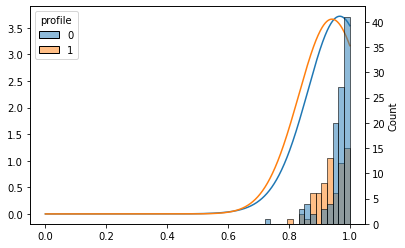

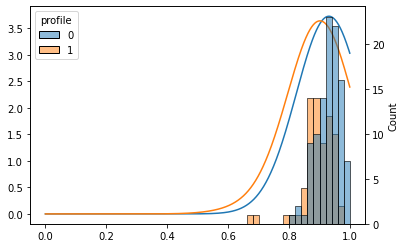

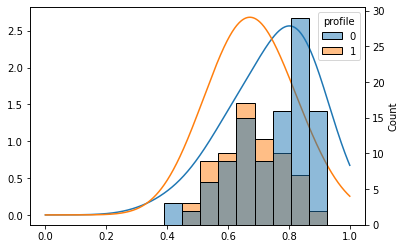

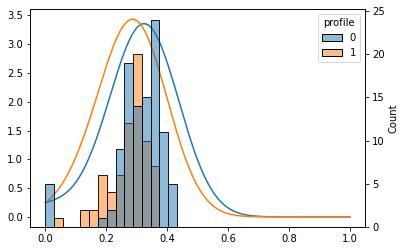

In [54]:
# For feature in important features
causing_dict = {}
for i, row in top_importance_df.iterrows():
    # print(row)
    contact, importance, bw_contact, diff = row
    # print()
# select a threshold beyond which one group is more likely than the other
    kde_df = pd.DataFrame([])
    for profile in [0,1]:
        contact_values = contact_df[contact_df.profile == profile][contact].values
        model = KernelDensity(bandwidth=0.1)
        model.fit(contact_values.reshape(-1, 1))
        x_test = np.linspace(0,1,1000).reshape(-1, 1)
        dens = np.exp(model.score_samples(x_test))
        kde_df[profile] = dens
        kde_df['freq'] = x_test
        sns.lineplot(x=x_test.flatten(), y=dens.flatten())
        
    bias_high_df = kde_df[kde_df[1] > kde_df[0]]

    interval_min = bias_high_df.freq.min()
    interval_max = bias_high_df.freq.max()

    plt.twinx()
    sns.histplot(data=contact_df, x=contact, hue='profile')
    plt.show()
    
    m1 = contact_df.profile == 1
    m2 = interval_min < contact_df[contact]
    m3 = contact_df[contact]< interval_max
    causing_mutants = contact_df[m1 & m2 & m3].mutant_id.unique()
    
    causing_dict[i] = causing_mutants
    # break
    
    # calculate the kde of each distribution
    # Fid the crosing point of the two distributions (ideally only one)
    
# Identify which mutants produce contact stability beyond the threshold
# Plot the mutants

In [50]:
top_importance_df.shape[0]

20

In [51]:

contact_idx = 0
w = plot_contacts(top_importance_df.iloc[[contact_idx]])

w.add_representation('spacefill', f".CA and ({' '.join(causing_dict[contact_idx])})", color='red')
w

NGLWidget()

In [52]:
contact_idx = 1
w = plot_contacts(top_importance_df.iloc[[contact_idx]])

w.add_representation('spacefill', f".CA and ({' '.join(causing_dict[contact_idx])})", color='red')
w

NGLWidget()

In [53]:
contact_idx = 2
w = plot_contacts(top_importance_df.iloc[[contact_idx]])

w.add_representation('spacefill', f".CA and ({' '.join(causing_dict[contact_idx])})", color='red')
w

NGLWidget()

In [ ]:
kde_df

,0,freq,1
0,0.869872,0.000000,0.116824
1,0.872822,0.001001,0.117551
2,0.875716,0.002002,0.118273
3,0.878556,0.003003,0.118990
4,0.881340,0.004004,0.119702
...,...,...,...
995,0.494542,0.995996,1.750778
996,0.489513,0.996997,1.738823
997,0.484508,0.997998,1.726814
998,0.479526,0.998999,1.714754


: 

In [ ]:
bias_high_df = kde_df[kde_df[1] > kde_df[0]]
if bias_high_df.freq.max() == 1:
    threshold = bias_high_df.freq.min()
else:
    threshold = bias_high_df.freq.max()

: 

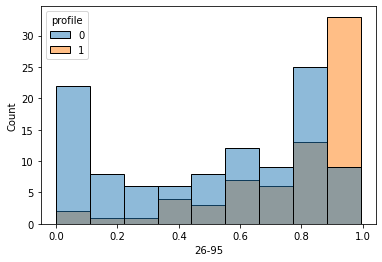

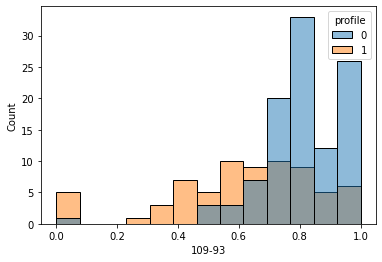

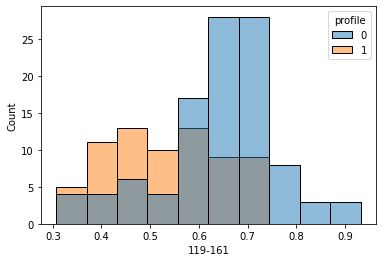

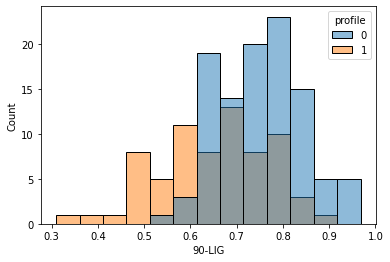

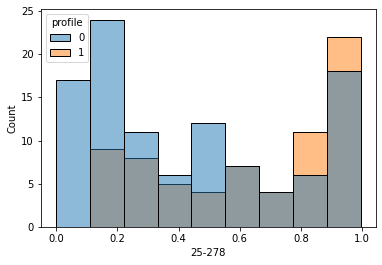

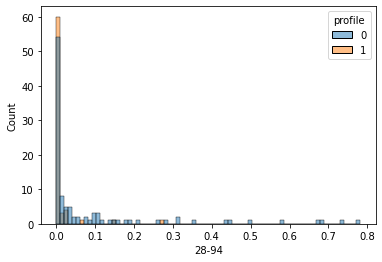

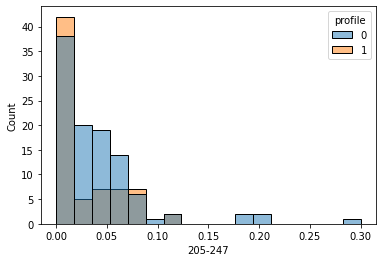

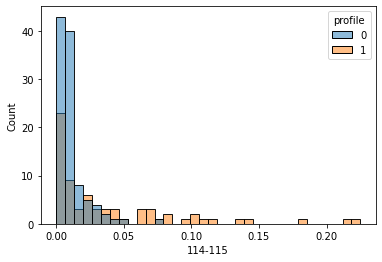

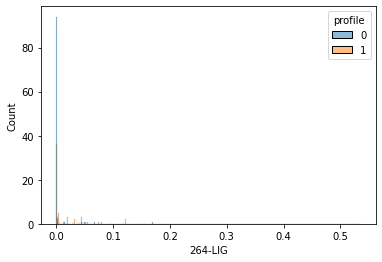

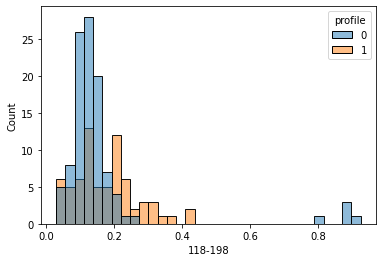

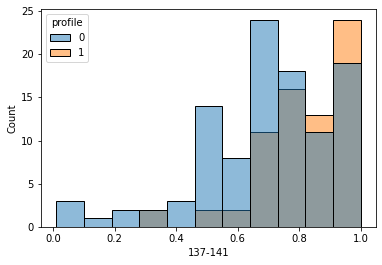

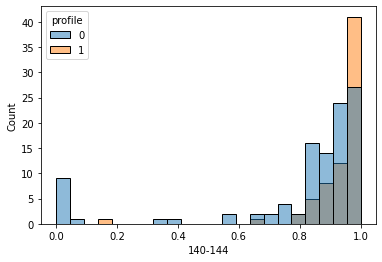

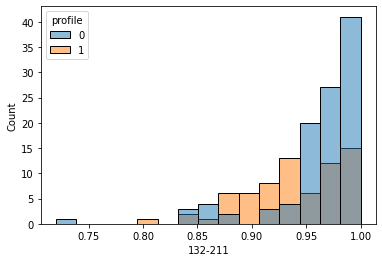

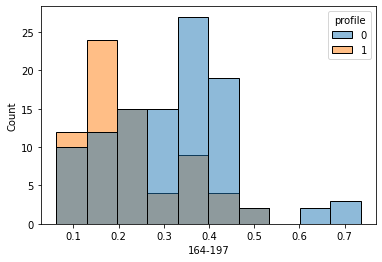

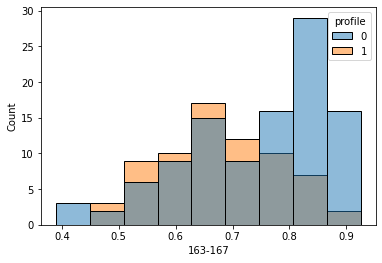

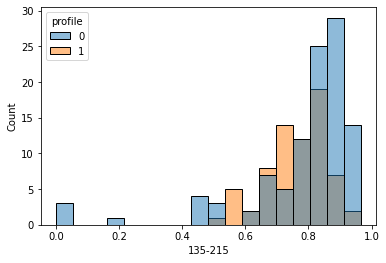

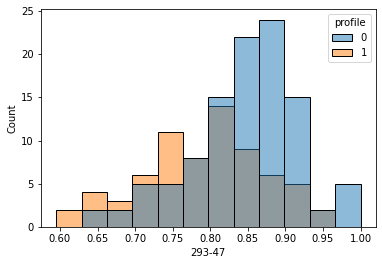

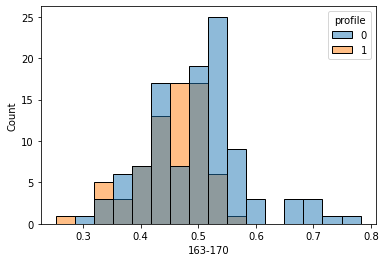

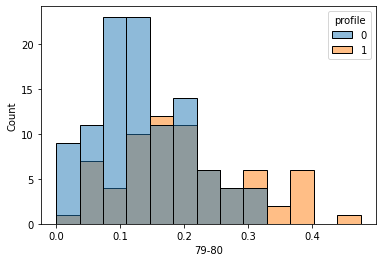

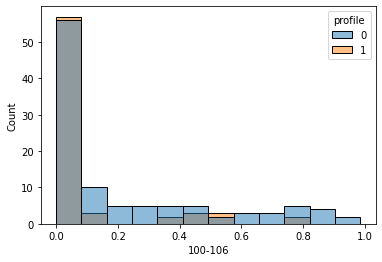

In [38]:
for contact in importance_df.iloc[:20].contact:
    sns.histplot(data=contact_df, x=contact, hue='profile')
    plt.show()

<AxesSubplot:xlabel='26-95', ylabel='Count'>

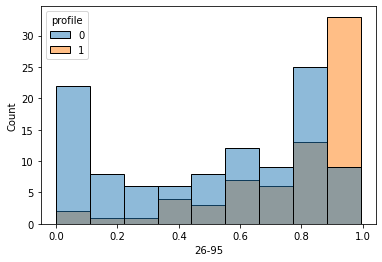

In [51]:
sns.histplot(data=contact_df, x='26-95', hue='profile')

<AxesSubplot:xlabel='109-93', ylabel='Count'>

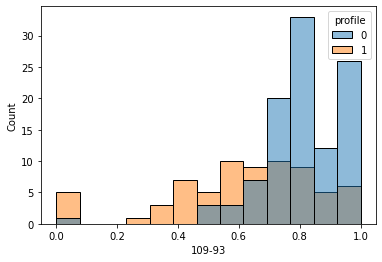

In [52]:
sns.histplot(data=contact_df, x='109-93', hue='profile')

### Mechanism Approach

In [64]:
model = DecisionTreeClassifier(class_weight='balanced')

In [65]:
temp_df = contact_df
temp_df = temp_df.drop(['26-95'], axis=1)
feature_cols = np.array([c for c in temp_df.columns if '-' in c])


In [66]:
X = temp_df[feature_cols]
y = temp_df['profile']

model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced')

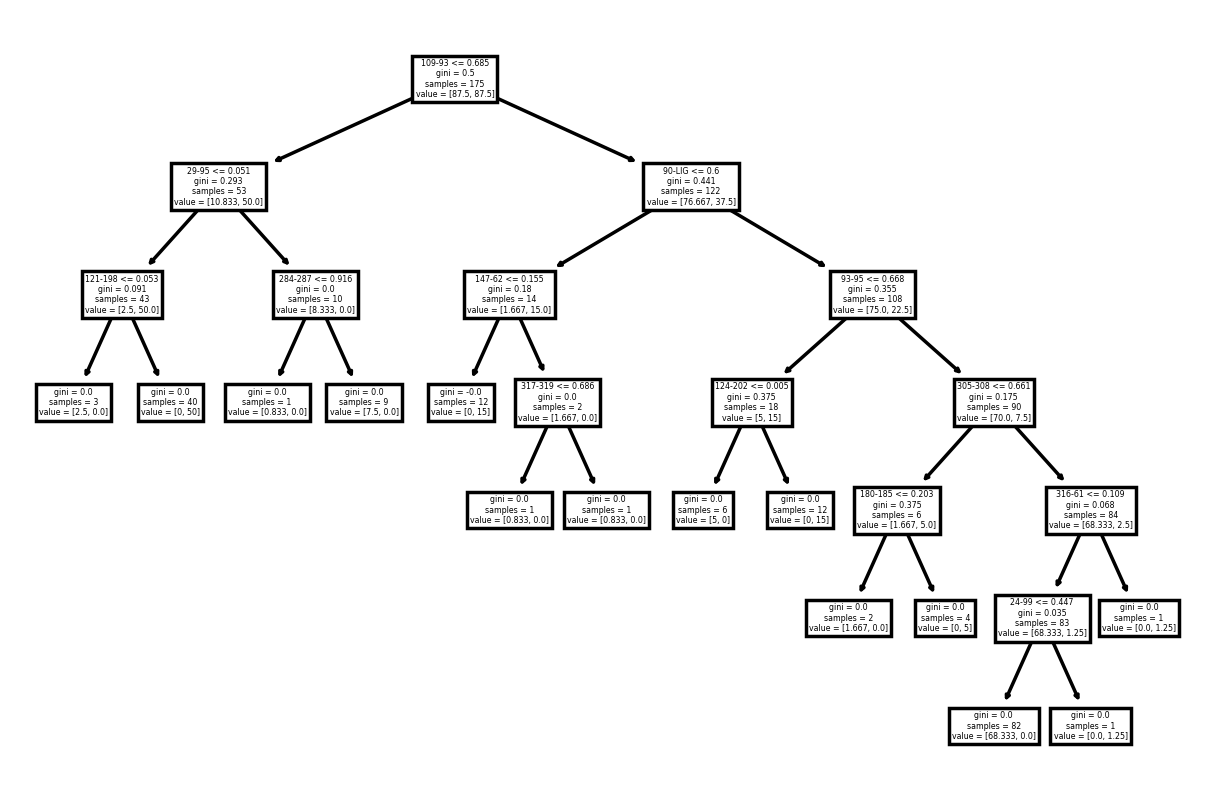

In [67]:
plt.figure(dpi=250)
plot_tree(model, feature_names=X.columns)
plt.show()

<AxesSubplot:xlabel='109-93', ylabel='Count'>

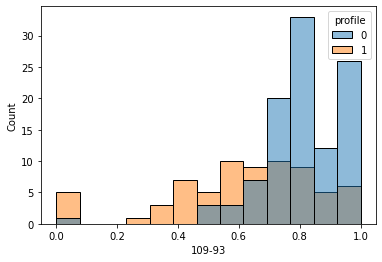

In [68]:
sns.histplot(data=contact_df, x='109-93', hue='profile')

In [69]:
m1 = contact_df.profile == 1
m2 = contact_df['109-93'] <= 0.685
mech1_index = contact_df[m1 & m2].index

In [70]:
len(mech1_index)

40

In [71]:
from tqdm import tqdm

In [72]:
set([1,2,3]) & set([3,4,5])

{3}

In [73]:
from sklearn.metrics import f1_score

In [74]:
# check for classification correlation with other features
class_corr_df = []
for feature in tqdm(feature_cols):
    best_threshold = [0,0,0]
    for val in contact_df[feature].unique():
        feature_mask = contact_df[feature] <= val
        score1 = f1_score(m2, feature_mask)
        score2 = f1_score(~m2, feature_mask)
        
        score = max(score1, score2)
        
        if score > best_threshold[-1]:
            best_threshold = [feature, val, score]
        
    class_corr_df.append(best_threshold)
        
class_corr_df = pd.DataFrame(class_corr_df, columns=['feature', 'val', 'score'])

100%|██████████| 4417/4417 [03:52<00:00, 18.97it/s] 


In [75]:
class_corr_df = class_corr_df.sort_values('score', ascending=False)

In [76]:
class_corr_df.head(10)

,feature,val,score
1081,109-93,0.682,1.000000
2066,86-LIG,0.110,0.862191
2647,44-87,0.003,0.860215
2046,114-115,0.050,0.859206
1391,24-27,0.623,0.858156
2237,25-29,0.015,0.856140
943,188-269,0.917,0.855019
3460,86-91,0.003,0.853147
2494,143-147,0.010,0.853147
3376,113-183,0.003,0.853147


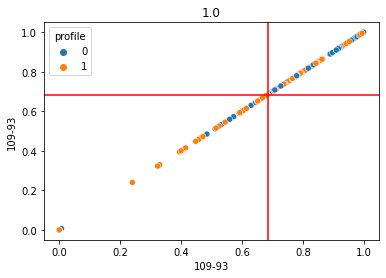

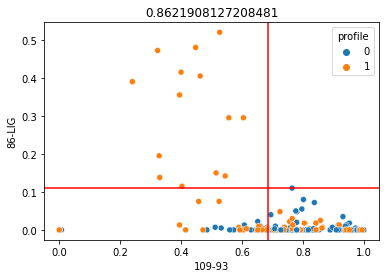

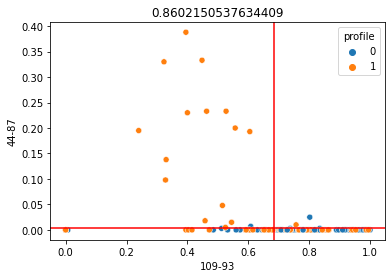

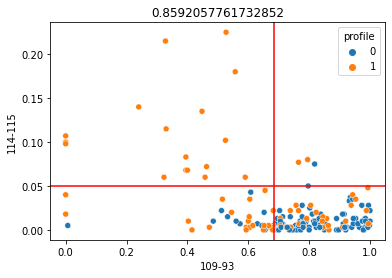

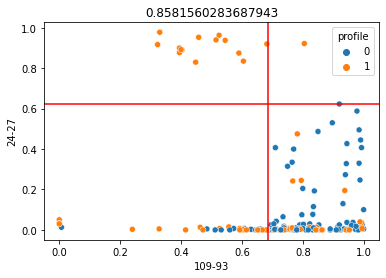

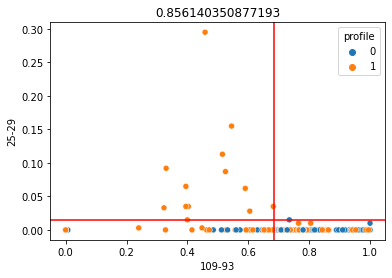

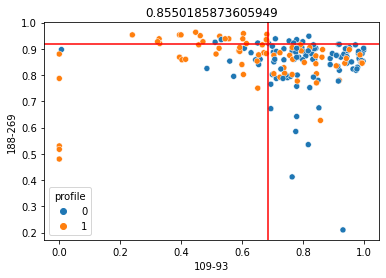

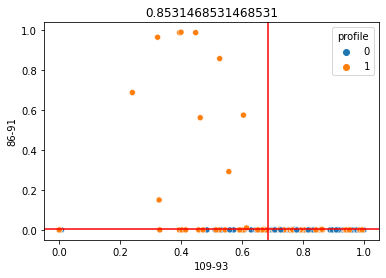

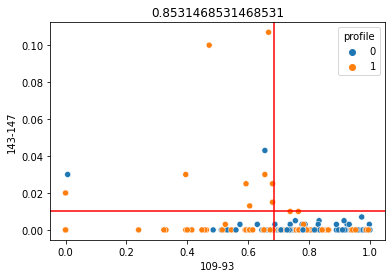

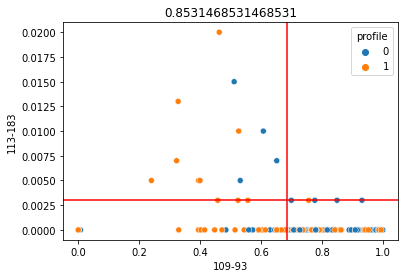

In [77]:
for feature, val, score in class_corr_df.values[:10]:
    
    sns.scatterplot(data=contact_df, x='109-93', y=feature, hue='profile')
    plt.title(score)
    plt.axvline(0.685, color='red')
    plt.axhline(val, color='red')
    plt.show()

In [78]:
bw_list = []

for c in class_corr_df.head(10).feature:
    bw_pair = []
    for res in c.split('-'):
                
        res = clean_bw_dict.get(res, res)
            
        bw_pair.append(res)
    
    bw_list.append('-'.join(map(str, bw_pair)))

In [79]:
high_corr_df = class_corr_df.head(10)

In [80]:
high_corr_df['thickness'] = 1
high_corr_df['bw'] = bw_list
high_corr_df['sense'] = [1] + [-11]*(high_corr_df.shape[0] - 1)
high_corr_df = high_corr_df[['feature', 'thickness', 'bw', 'sense']]

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [81]:
plot_contacts(high_corr_df)

NGLWidget()

In [26]:
high_corr_df['bw'] = bw_list

/home/amorales/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


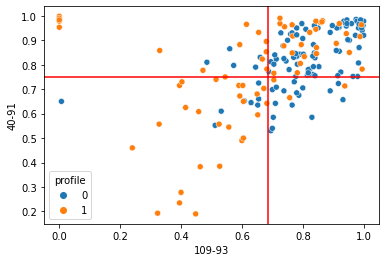

In [90]:
sns.scatterplot(data=contact_df, x='109-93', y='40-91', hue='profile')
plt.axvline(0.685, color='red')
plt.axhline(0.750, color='red')

In [13]:
feature = '109-93'

In [14]:
contact_df.loc[contact_df.mutant_id == 'wt', feature]

248    0.780
249    0.818
250    0.910
251    0.728
252    0.560
Name: 109-93, dtype: float64

<AxesSubplot:xlabel='109-93', ylabel='29-95'>

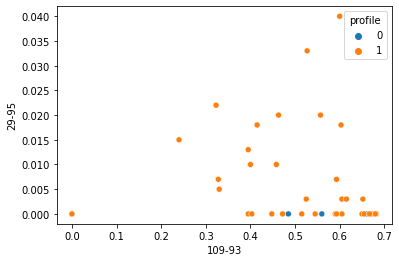

In [15]:
m1 = contact_df['109-93'] <= 0.685
m2 = contact_df['29-95'] <= 0.051
sns.scatterplot(data=contact_df[m1 & m2], x='109-93', y='29-95', hue='profile')

<AxesSubplot:xlabel='109-93', ylabel='29-95'>

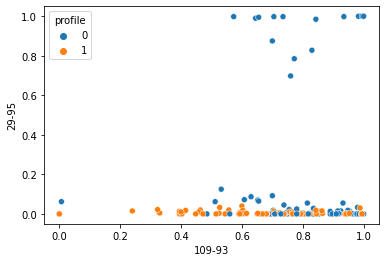

In [16]:
sns.scatterplot(data=contact_df, x='109-93', y='29-95', hue='profile')

In [14]:
contact_df[(contact_df['109-93'] <= 0.685) & (contact_df.profile == 1)].mutant_id.unique().size

11

In [15]:
contact_df[(contact_df.profile == 1)].mutant_id.unique().size

14

In [39]:
clean_contact_df, contact_corr_dict = get_low_corr_df(contact_df, feature_cols, 0.5)

In [40]:
contact_corr_dict['109-93']

Index(['114-LIG', '109-93', '194-LIG', '195-LIG'], dtype='object')

In [45]:
np.corrcoef(x=contact_df['109-93'], y=contact_df['114-LIG'])

array([[1.        , 0.50363689],
       [0.50363689, 1.        ]])

In [47]:
from sklearn.linear_model import LinearRegression

In [52]:
m = LinearRegression()
m.fit(contact_df[['109-93']], y=contact_df['195-LIG'])
m.score(contact_df[['109-93']], y=contact_df['195-LIG'])

0.26626735666089696

In [53]:
m = LinearRegression()
m.fit(contact_df[['109-93']], y=contact_df['114-LIG'])
m.score(contact_df[['109-93']], y=contact_df['114-LIG'])

0.25365012194207537

In [44]:
np.corrcoef(x=contact_df['109-93'], y=contact_df['195-LIG'])

array([[ 1.      , -0.516011],
       [-0.516011,  1.      ]])

<AxesSubplot:xlabel='109-93', ylabel='195-LIG'>

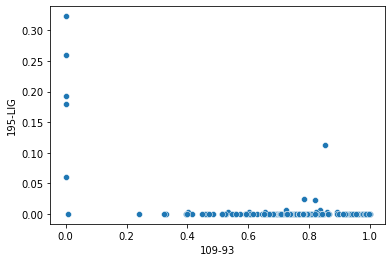

In [43]:
sns.scatterplot(data=contact_df, x='109-93', y='195-LIG')

In [14]:
from glob import glob
import os
os.chdir('/home/amorales/Documents/projects/bias_2')
import shutil

In [17]:
# Delete old dataset contacts
# for system in glob('data/interim/contacts/*'):
#     if not os.path.isdir(system):
#         continue

#     replica_path = glob(f'{system}/*')
#     n_replica = len(replica_path)
#     print(f'{system}: {n_replica}')

#     for replica in replica_path[:-5]:
#         print(f'\t{replica}')
#         shutil.rmtree(replica)

In [ ]:
# It is possible that a sliding window will reveal that other systems also visit this conformation
contact_table_list = glob(f"data/interim/contacts/*/*/")
# For each replica:
# Load contact table
# Read interactions involving residues 109 and 93
# For a given window size
# Compute interaction frequency along the simulation


### Multi Decission Tree approach

In [10]:
def get_tree_dict(text, d):
    
    # print(text)
    val = re.findall('[\d\.]+$', text[0])
    feature = re.findall('[^\s-]+-[^\s-]+', text[0])
    
    if not feature:
        return d
    
    feature = feature[0]
    val = val[0]
    
    level_list = [r.count('|') for r in text[1:]]
    
    min_level = level_list.index(min(level_list))
    
    t1, t2 =text[1:min_level+1], text[min_level+2:]

    d[feature]= [val, {}]
    
    for t in [t1, t2]:
        d[feature][1] = get_tree_dict(t, d[feature][1])
    
    return d

In [11]:
accuracy = 1
res_to_drop = ''
temp_df = contact_df.copy()

## Randomize labels
# id_profile_array = temp_df[['mutant_id', 'profile']].drop_duplicates().values
# id_profile_array[:, 0] = np.random.permutation(id_profile_array[:, 0])
# r_id_profile_dict = dict(id_profile_array)
# temp_df.profile = temp_df.mutant_id.apply(lambda x: r_id_profile_dict[x])

safety_counter = 0
acc_list = []
tree_dict_list = []
pred_list = []
while True:
    
    # print(f"Res to drop: {res_to_drop}")
    if res_to_drop:
        temp_df = temp_df.drop(res_to_drop, axis=1)
        
    feature_cols = [c for c in temp_df.columns if '-' in c]
    
    X = temp_df[feature_cols].values
    y = temp_df['profile'].values
    
    model = DecisionTreeClassifier(max_depth=2,
                                class_weight='balanced',
                                min_impurity_decrease= 0.05, min_samples_split=10)
    
    model.fit(X, y)
    
    pred = model.predict(X)
    
    sample_weight, class_weights = get_sample_balanced_weight(y)
    accuracy = accuracy_score(y, pred, sample_weight=sample_weight)
    
    text = export_text(model, feature_names=feature_cols)
    
    tree_dict = get_tree_dict(text.rstrip().split('\n'), {})
    
    # if accuracy <= 0.5:
    #     break
    if accuracy > 0.84:
        safety_counter+=1
        
        # print(text)
        
        tree_dict_list.append(tree_dict)
        acc_list.append(accuracy)
        pred_list.append(pred)

    try:
        res_to_drop = list(tree_dict.keys())[0]
    except:
        break


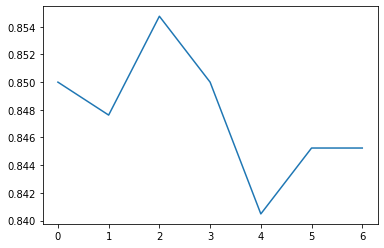

In [12]:
sns.lineplot(x=range(len(acc_list)), y=acc_list)
plt.show()

In [13]:
# feature_list = []
# dict_list = tree_dict_list
# counter = 0
# while True:
#     counter += 1
#     if counter == len(dict_list):
#         break
    
#     d = dict_list[counter]    
#     feature_list += list(d.keys())
#     for split, v in d.values():
#         if v and type(v) == dict:
#             dict_list.append(v)

In [14]:
feature_sets = []
for d in tree_dict_list:
    # print(d)
    main_feature = list(d.keys())
    # print(main_feature)
    secondary_features = []
    if d.values():
        secondary_features = list(list(d.values())[0][1].keys())
    # print(secondary_features)
    feature_sets.append(main_feature + secondary_features)

In [15]:
' '.join(set([res for s in feature_sets for contact in s for res in contact.split('-')]))

'258 262 29 137 211 161 26 LIG 100 114 293 20 25 107 65 95 93 90 24 214 273 47 109 281 183 265 194 256 101 182 119 195 141 253 106 148'

In [16]:
y = contact_df.profile
model = DecisionTreeClassifier(max_depth=2,
                                class_weight='balanced',
                                min_impurity_decrease= 0.05, min_samples_split=10)
set_pred_dict = {}
for i in range(len(feature_sets)):
        set_comb = feature_sets[i]
        X = contact_df[set_comb]
        
        model.fit(X, y)
        pred = model.predict(X)

        set_pred_dict[tuple(set_comb)] = pred

In [17]:
pred_array = np.stack(set_pred_dict.values())

/home/amorales/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
# ensemble_pred = (pred_array.mean(axis=0) > 0.5).astype(int)
# sample_weight, class_weights = get_sample_balanced_weight(y)
# accuracy = accuracy_score(y, ensemble_pred, sample_weight=sample_weight)
# accuracy

In [19]:
set_acc_list = []
for comb in list(itertools.combinations(range(len(acc_list)), 2)):
    set_pred = (pred_array[list(comb)].mean(axis=0) > 0.5).astype(int)
    
    sample_weight, class_weights = get_sample_balanced_weight(y)
    accuracy = accuracy_score(y, set_pred, sample_weight=sample_weight)
    set_acc_list.append([accuracy, comb])

In [20]:
set_acc_df = pd.DataFrame(set_acc_list, columns = ['acuracy', 'comb'])

<AxesSubplot:xlabel='acuracy', ylabel='Count'>

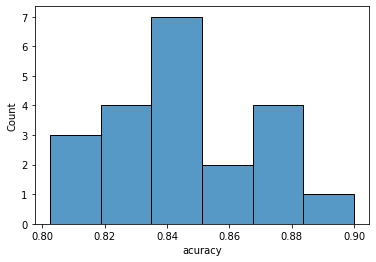

In [21]:
sns.histplot(data=set_acc_df, x='acuracy')

In [22]:
set_acc_df.sort_values('acuracy')

,acuracy,comb
0,0.802381,"(0, 1)"
7,0.809524,"(1, 3)"
10,0.809524,"(1, 6)"
6,0.821429,"(1, 2)"
1,0.821429,"(0, 2)"
8,0.821429,"(1, 4)"
2,0.830952,"(0, 3)"
5,0.835714,"(0, 6)"
9,0.838095,"(1, 5)"
3,0.840476,"(0, 4)"


In [27]:
all_contacts = feature_sets[2] + feature_sets[5]
all_contacts

['119-161', '137-141', '93-95', '182-24', '107-114', '258-265']

In [40]:
for c in all_contacts:
    print(c)
    if c in contact_corr_dict:
        print(contact_corr_dict[c])
    else: 
        corr_key_list = []
        for key, val in contact_corr_dict.items():
            if c in val:
                corr_key_list.append(key)
        print(corr_key_list)

119-161
Index(['172-190', '119-161', '164-197'], dtype='object')
137-141
Index(['142-145', '137-141'], dtype='object')
93-95
Index(['92-94', '93-97', '92-95', '93-95', '26-28', '92-97', '91-96', '182-95',
       '37-97'],
      dtype='object')
182-24
Index(['297-301', '298-300', '182-24', '180-24', '183-24', '303-69', '25-28',
       '24-LIG', '297-302', '127-303', '296-301', '300-73', '301-54',
       '301-310', '295-300'],
      dtype='object')
107-114
Index(['169-190', '107-190', '107-114', '114-169'], dtype='object')
258-265
Index(['284-288', '275-279', '260-264', '272-274', '27-32', '286-287',
       '23-276', '23-279', '258-265', '24-276'],
      dtype='object')


In [75]:
set1_pred = set_pred_dict[tuple(['119-161', '137-141', '93-95'])]
set2_pred = set_pred_dict[tuple(['182-24', '107-114', '258-265'])]

In [77]:
beset_pred_df = pd.DataFrame({'s1': set1_pred, 's2': set2_pred, 'true': y})

In [79]:
beset_pred_df.value_counts(['s1', 's2', 'true'])

s1  s2  true
0   0   0       66
1   1   1       58
0   1   0       22
1   0   0       14
0   1   1        7
1   1   0        3
    0   1        3
0   0   1        2
dtype: int64

In [24]:
feature_sets[23]

['182-264', '109-113', '94-LIG']

In [ ]:
X = contact_df[feature_sets[1]]

<AxesSubplot:ylabel='Count'>

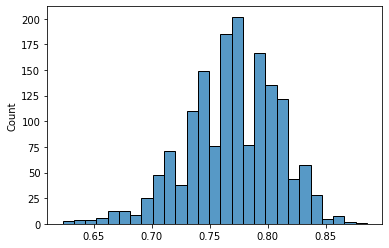

In [ ]:
sns.histplot(combiantion_scores.flatten())

<AxesSubplot:>

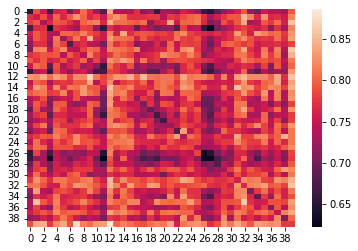

In [ ]:
sns.heatmap(combiantion_scores)

In [ ]:
contact_df[set_comb]

,138-218,117-288,139-144,138-218,117-288,139-144
3,0.003,0.030,0.155,0.003,0.030,0.155
4,0.000,0.030,0.000,0.000,0.030,0.000
5,0.003,0.055,0.000,0.003,0.055,0.000
6,0.000,0.068,0.013,0.000,0.068,0.013
7,0.003,0.095,0.000,0.003,0.095,0.000
...,...,...,...,...,...,...
248,0.000,0.075,0.000,0.000,0.075,0.000
249,0.000,0.080,0.000,0.000,0.080,0.000
250,0.000,0.122,0.000,0.000,0.122,0.000
251,0.000,0.098,0.000,0.000,0.098,0.000


In [ ]:
model.fit(X, y)

In [ ]:
feature_cols = np.array([c for c in contact_df.columns if '-' in c])

In [ ]:
imp_feature_list = [feature_cols[int(idx)] for idx in feature_list]

In [ ]:
' '.join(np.unique([res for contact in imp_feature_list for res in contact.split('-')]))

'102 103 104 106 109 110 111 112 113 115 116 118 119 121 126 135 137 138 139 141 144 145 146 148 152 153 157 158 160 161 164 165 166 167 172 175 176 177 178 179 180 181 182 183 184 185 186 19 190 191 192 195 197 198 20 202 205 208 212 215 216 217 220 221 222 23 235 236 239 240 241 242 243 246 25 250 251 252 253 254 255 258 26 260 263 264 268 27 271 272 273 275 278 28 281 282 283 284 286 287 288 289 29 291 292 294 296 299 300 302 304 305 306 307 310 312 313 34 39 48 49 51 52 53 54 55 56 57 62 63 65 66 67 68 69 71 73 74 76 77 79 80 81 86 87 90 91 92 93 94 95 96 97 98 99 LIG'

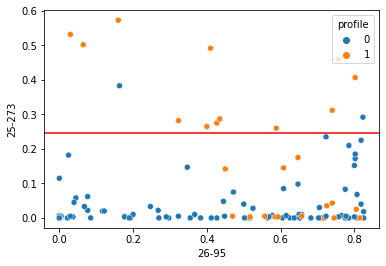

In [ ]:
sns.scatterplot(data=contact_df[contact_df['26-95'] < 0.826], x='26-95', y='25-273', hue='profile')
plt.axhline(0.247, color='red')

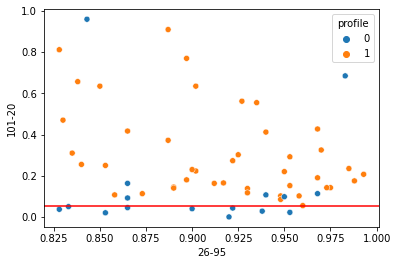

In [ ]:
sns.scatterplot(data=contact_df[contact_df['26-95'] > 0.826], x='26-95', y='101-20', hue='profile')

plt.axhline(0.053, color='red')

In [ ]:
for i in ['26-95', '25-273', '101-20']:
    
    print(contact_corr_dict[i])

Index(['27-94', '29-95', '26-95', '22-94'], dtype='object')
Index(['181-273', '184-25', '183-25', '25-278', '25-273', '94-LIG', '183-22',
       '21-99', '22-LIG', '25-272', '20-94', '106-21', '25-271', '25-268'],
      dtype='object')
Index(['101-99', '100-20', '103-19', '101-20', '102-19', '106-20', '104-19'], dtype='object')


In [ ]:
for i in ['26-95', '25-273', '101-20']:
    
    print(contact_corr_dict[i])

## Flexibility

In [8]:
flex_df = pd.read_csv('data/processed/flex_features.csv', index_col=0)
flex_df.mutant_id = flex_df.mutant_id.astype(str)

feature_cols = np.array([c for c in flex_df.columns if c.isnumeric()])
non_feature_cols = np.array([c for c in flex_df.columns if not c.isnumeric()])

flex_df = flex_df[np.concatenate([non_feature_cols ,feature_cols])]

In [9]:
flex_df

,mutant_id,profile,19,20,21,22,23,24,25,26,...,310,311,312,313,314,315,316,317,318,319
0,109,1,4.211420,2.513803,1.844661,1.863888,2.256069,1.869664,1.144191,1.032852,...,1.509766,1.848526,2.106486,2.247290,2.494842,2.749167,3.150040,3.621724,4.463398,5.165889
1,109,1,5.563496,3.828354,2.423505,1.402700,1.227888,1.234740,1.087272,0.971446,...,1.436394,1.689852,1.902832,1.977179,2.378102,2.674215,2.904181,3.361450,4.287984,4.519456
2,109,1,3.504766,2.309321,1.248856,1.301904,1.435488,1.202122,0.911088,0.776429,...,1.317082,1.554119,1.713232,1.824281,2.030403,2.248032,2.522814,2.785424,3.135631,3.734490
3,109,1,1.576226,0.989922,0.861522,0.790492,0.895254,1.086151,0.907983,0.911653,...,1.012438,1.307841,1.373371,1.428693,1.700772,1.945559,2.086376,2.219891,2.571845,3.532208
4,109,1,5.694250,3.847937,1.293793,1.059118,1.014157,1.036015,0.890752,0.903058,...,2.198102,2.639661,3.004696,3.095245,3.388019,3.743953,4.099511,4.349956,5.080657,5.523666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,91,0,3.127324,2.484367,1.247039,0.884632,1.032816,0.917796,0.773597,0.909435,...,0.980765,1.240740,1.379149,1.429359,1.650416,1.926936,2.120754,2.225418,2.584781,3.225188
166,91,0,4.782806,3.074765,2.088496,1.098357,1.142762,0.928404,0.725476,0.878693,...,0.932766,1.144475,1.174021,1.271693,1.531455,1.660894,1.775964,2.008559,2.365722,3.014671
167,91,0,4.827537,3.568371,2.713925,1.637304,1.398285,1.060720,0.967755,1.297576,...,0.918606,1.168361,1.158127,1.124233,1.402936,1.613326,1.633106,1.739490,2.148624,3.010393
168,91,0,3.413459,2.466988,1.701208,1.068857,1.161844,1.018444,0.840131,0.982915,...,0.922589,1.125466,1.173900,1.188655,1.420730,1.598557,1.713746,1.817017,2.119671,2.908321


In [41]:
clean_flex_df, flex_corr_dict = get_low_corr_df(flex_df, feature_cols, 0.6)
# Create a list with the new feature cols
clean_feature_cols = np.array([c for c in clean_flex_df.columns if  c.isnumeric()])

In [42]:
clean_flex_df

,mutant_id,profile,19,47,102,235
0,109,1,4.211420,0.598653,0.861170,2.843673
1,109,1,5.563496,0.566837,0.745278,3.382459
2,109,1,3.504766,0.520859,0.728858,3.320768
3,109,1,1.576226,0.514178,0.662758,3.766575
4,109,1,5.694250,0.673166,0.784534,4.146808
...,...,...,...,...,...,...
165,91,0,3.127324,0.570469,1.092962,4.477992
166,91,0,4.782806,0.570239,1.406034,2.779571
167,91,0,4.827537,0.674941,1.105363,5.417285
168,91,0,3.413459,0.577779,0.962055,4.606161


### Compare distribtution between signaling profiles

In [44]:
# X = clean_flex_df[clean_feature_cols].values
# y = clean_flex_df['profile'].values
# groups = clean_flex_df['mutant_id'].values

X = flex_df[feature_cols].values
y = flex_df['profile'].values
groups = flex_df['mutant_id'].values

In [45]:
# model = DecisionTreeClassifier(max_depth=2,
#                                 class_weight='balanced',
#                                 min_impurity_decrease= 0.05, min_samples_split=10)

model = DecisionTreeClassifier(class_weight='balanced')

In [46]:
model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced')

In [47]:
pred = model.predict(X)

In [48]:
sample_weight, class_weights = get_sample_balanced_weight(y)
score = accuracy_score(y, pred, sample_weight=sample_weight)

In [49]:
score

1.0

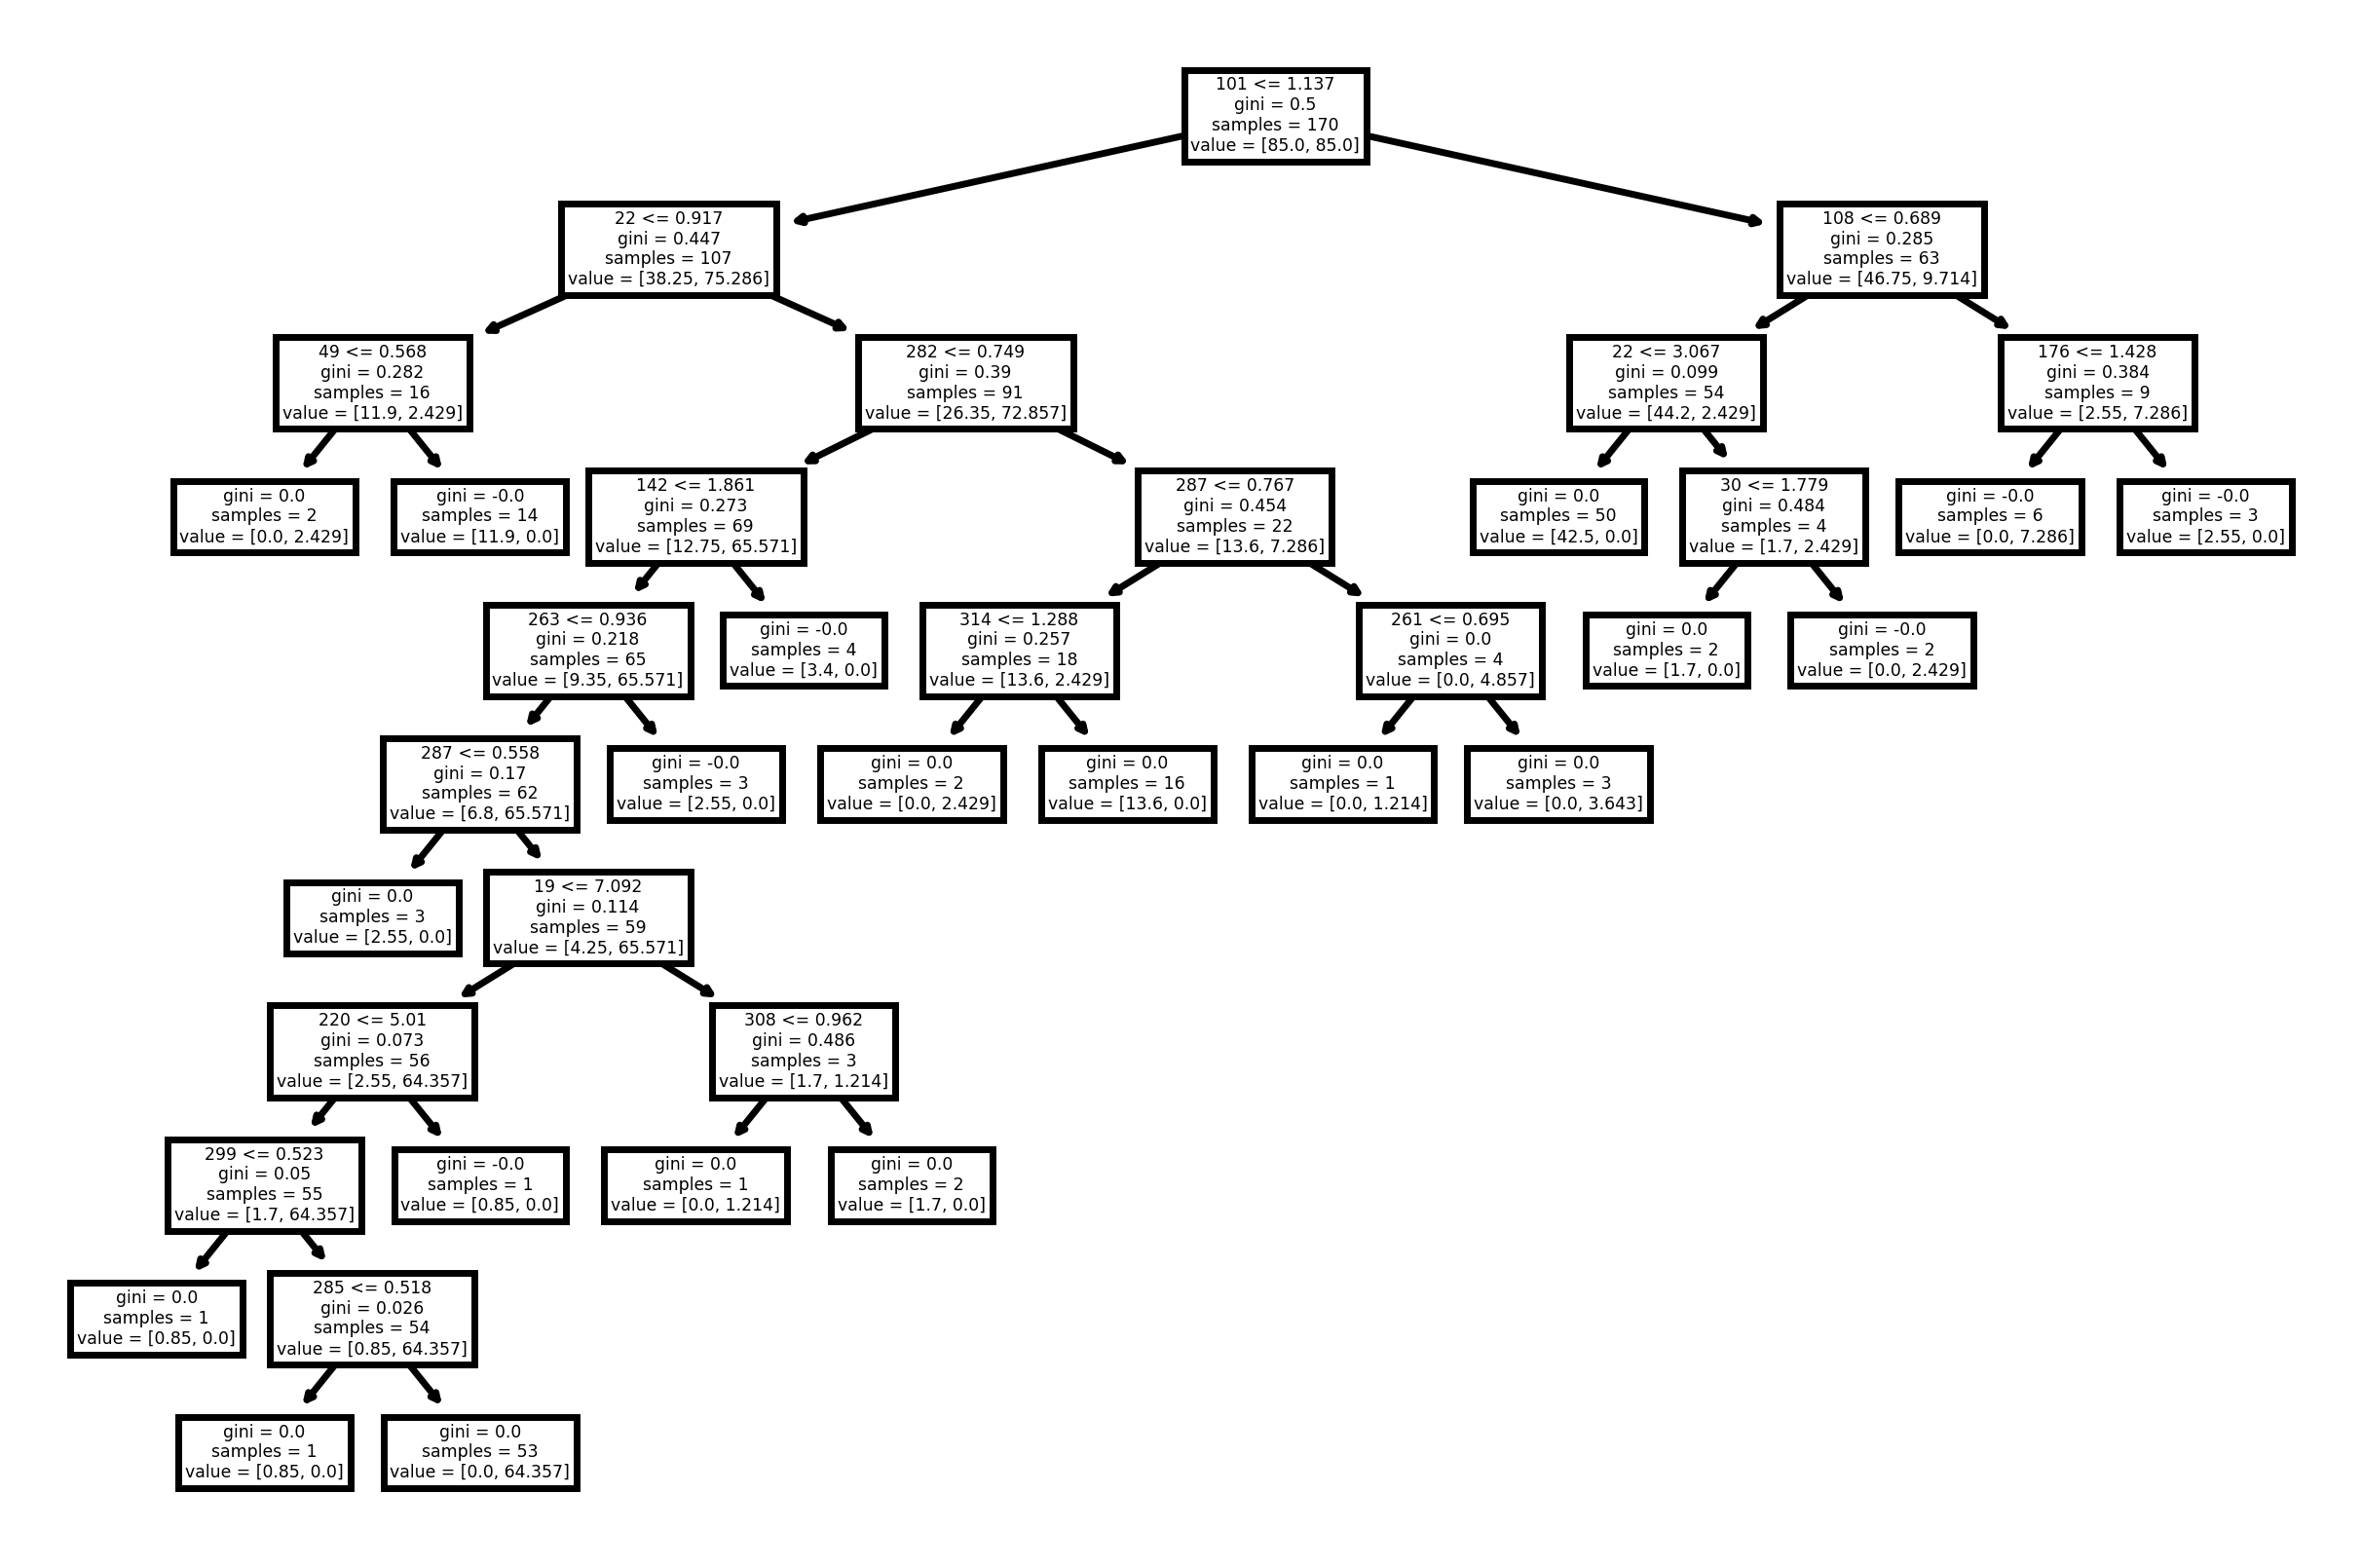

In [50]:
plt.figure(dpi=500)
plot_tree(model, feature_names=feature_cols,)
plt.show()

In [54]:
flex_corr_dict['101']

Index(['98', '99', '100', '101'], dtype='object')

In [58]:
(flex_df.mutant_id == 'wt').sum()

0

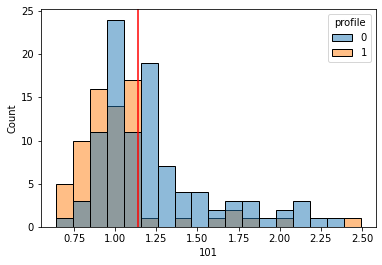

In [56]:
sns.histplot(data=flex_df, x='101', hue='profile')
plt.axvline(1.137, color='red')

### Position

In [5]:
pos_cols = []
for res in feature_cols:
    for coord in  ['x', 'y', 'z']:
        pos_cols.append(f"{res}_{coord}")

In [23]:
X, y, groups = pickle.load(open('data/processed/real_positions.pk', 'rb'))
X = X.reshape(175,400, 289*3).mean(axis=1)

In [24]:
pos_df = pd.DataFrame(X, columns = pos_cols)

In [25]:
clean_pos_df, pos_corr_dict = get_low_corr_df(pos_df, pos_cols, 0.7)
# Create a list with the new feature cols
clean_feature_cols = np.array([c for c in clean_pos_df.columns if '_' in c])

In [26]:
X = clean_pos_df[clean_feature_cols].values
# y = clean_pos_df['profile'].values
# groups = clean_pos_df['mutant_id'].values

In [27]:
model = DecisionTreeClassifier(max_depth=3,
                                class_weight='balanced',
                                min_impurity_decrease= 0.05, min_samples_split=10)

In [28]:
model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_impurity_decrease=0.05, min_samples_split=10)

In [29]:
pred = model.predict(X)

In [30]:
sample_weight, class_weights = get_sample_balanced_weight(y)
score = accuracy_score(y, pred, sample_weight=sample_weight)

In [31]:
score

0.7333333333333335

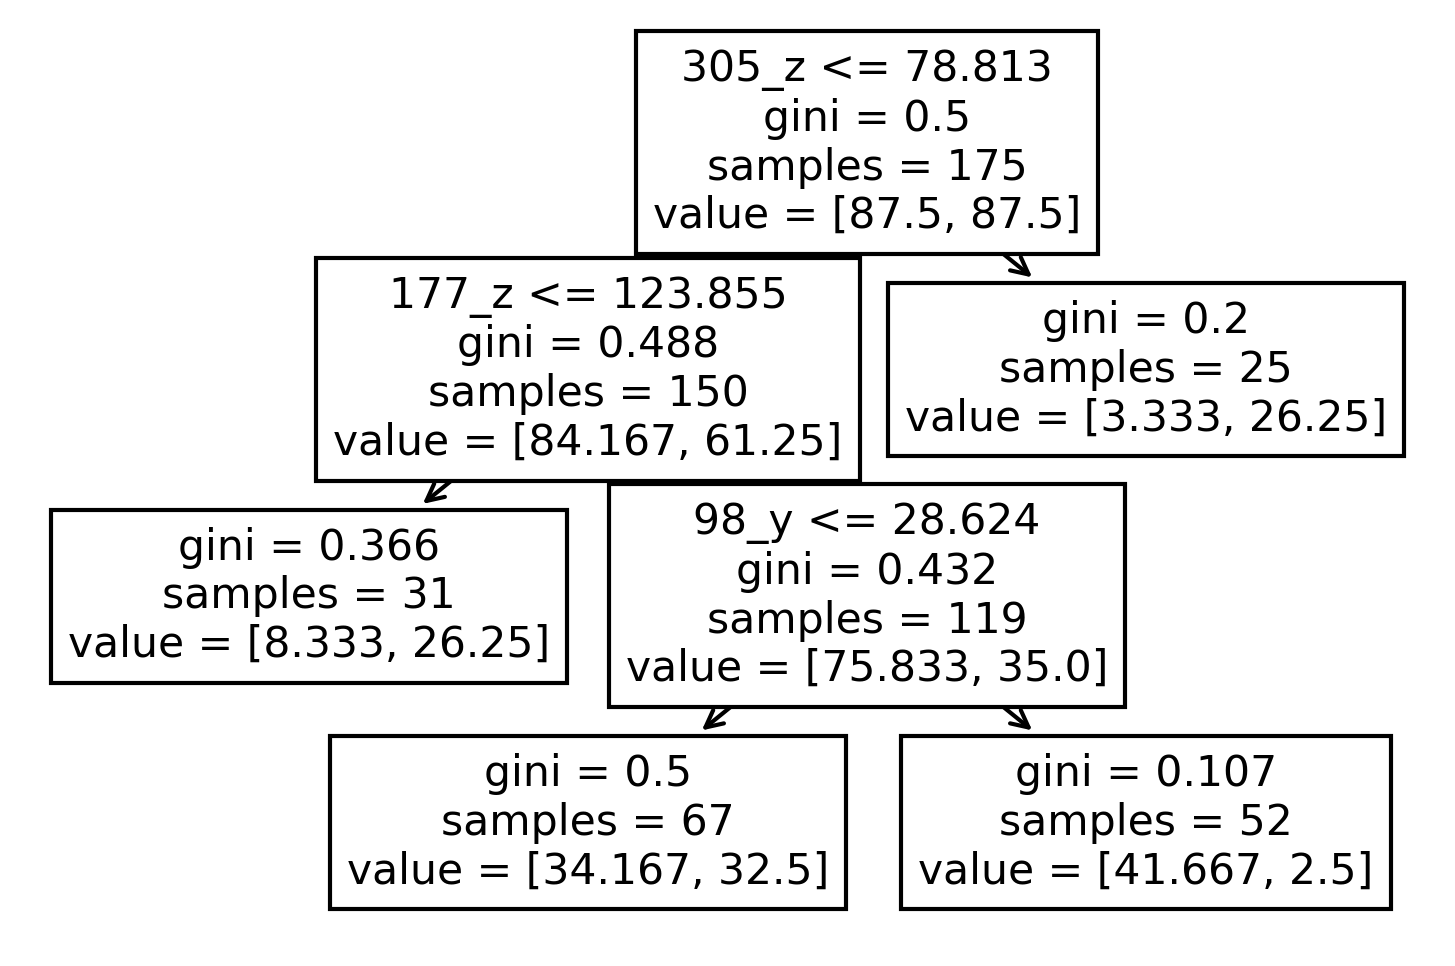

In [32]:
plt.figure(dpi=300)
plot_tree(model, feature_names=clean_pos_df.columns)
plt.show()

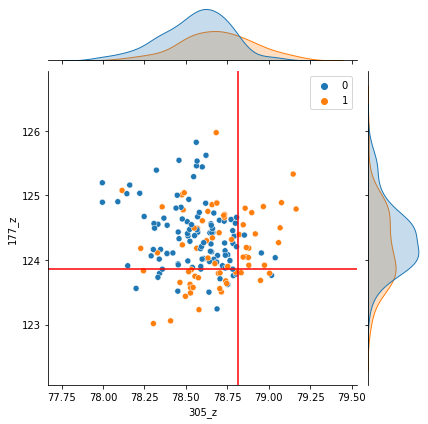

In [54]:
plot = sns.jointplot(data=clean_pos_df, x='305_z', y='177_z', hue=y)
plot.ax_joint.axvline(78.813, color='red')
plot.ax_joint.axhline(123.855, color='red')
plt.show()


<Figure size 1800x1200 with 0 Axes>

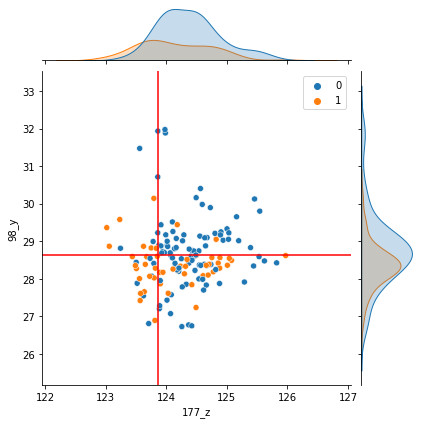

In [48]:
plt.figure(dpi=300)
mask = clean_pos_df['305_z'] < 78.813
plot = sns.jointplot(data = clean_pos_df[mask], x='177_z', y='98_y', hue=y[mask])
plot.ax_joint.axvline(123.855, color='red')
plot.ax_joint.axhline(28.624, color='red')


# plt.figure(dpi=300)
# mask = clean_pos_df['305_z'] < 78.813
# sns.scatterplot(data=clean_pos_df[mask], x='177_z', y='98_y', hue=y[mask])
# plt.axvline(123.855, color='red')
# plt.axhline(28.624, color='red')

In [20]:
for i in ['305_z', '177_z', '98_y']:
    
    print(pos_corr_dict[i])

Index(['305_z', '306_z', '309_z'], dtype='object')
Index(['177_z', '189_z', '192_z', '193_z', '195_z', '196_z', '197_z', '199_z',
       '200_z', '201_z', '202_z', '203_z', '204_z', '205_z', '206_z', '207_z',
       '208_z', '209_z', '210_z', '212_z', '213_z', '216_z'],
      dtype='object')
Index(['98_y', '99_y'], dtype='object')


In [22]:
rX, y, groups = pickle.load(open('data/processed/real_positions.pk', 'rb'))
rX = rX.reshape(175,400, 289*3).mean(axis=1)

In [ ]:
pos_df = pd.DataFrame(X, columns = pos_cols)